In [1]:
## Import libraries
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
np.random.seed(421)

### 1. Loading the data

#### 1.1- Binary alphadigits

In [2]:
## Unzip the data
import zipfile

with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('.')


In [3]:
##  AlphaDigits dataset
path_AlDi = './data/binaryalphadigs.mat'
data_alphadigits = loadmat(path_AlDi) 

In [4]:
data_alphadigits.keys()

dict_keys(['__header__', '__version__', '__globals__', 'dat', 'numclass', 'classlabels', 'classcounts'])

In [5]:
print(data_alphadigits['dat'].shape) ## shape (36,39) : 36 characters, 39 samples per character
print(data_alphadigits['dat'][0][0].shape) ## shape (20,16), the first sample of the first character.

(36, 39)
(20, 16)


In [6]:
data_alphadigits['classlabels'] = data_alphadigits['classlabels'].reshape(-1) ## 36 letters
data_alphadigits['classlabels']

array([array(['0'], dtype='<U1'), array(['1'], dtype='<U1'),
       array(['2'], dtype='<U1'), array(['3'], dtype='<U1'),
       array(['4'], dtype='<U1'), array(['5'], dtype='<U1'),
       array(['6'], dtype='<U1'), array(['7'], dtype='<U1'),
       array(['8'], dtype='<U1'), array(['9'], dtype='<U1'),
       array(['A'], dtype='<U1'), array(['B'], dtype='<U1'),
       array(['C'], dtype='<U1'), array(['D'], dtype='<U1'),
       array(['E'], dtype='<U1'), array(['F'], dtype='<U1'),
       array(['G'], dtype='<U1'), array(['H'], dtype='<U1'),
       array(['I'], dtype='<U1'), array(['J'], dtype='<U1'),
       array(['K'], dtype='<U1'), array(['L'], dtype='<U1'),
       array(['M'], dtype='<U1'), array(['N'], dtype='<U1'),
       array(['O'], dtype='<U1'), array(['P'], dtype='<U1'),
       array(['Q'], dtype='<U1'), array(['R'], dtype='<U1'),
       array(['S'], dtype='<U1'), array(['T'], dtype='<U1'),
       array(['U'], dtype='<U1'), array(['V'], dtype='<U1'),
       array(['W'], dtyp

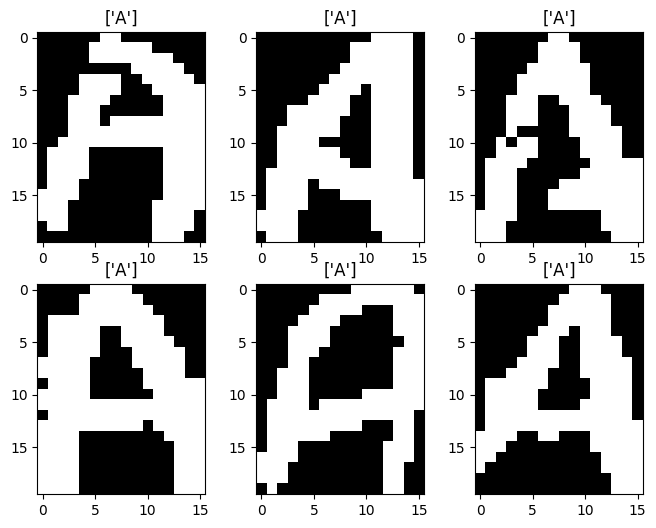

In [7]:
## visualize the first 6 A
fig, ax = plt.subplots(2,3, figsize=(8,6))
for i in range(6):
    ax[i//3, i%3].imshow(data_alphadigits['dat'][10][i].reshape(20,16), cmap='gray')
    ax[i//3, i%3].set_title(data_alphadigits['classlabels'][10])
plt.show()

#### 1.2- MNIST dataset

In [8]:
##We load MNIST dataset from keras, so to have access to images and labels.
## We could not access the yann.lecun.com/exdb/mnist/ website, so we used the keras library to load the dataset.

In [9]:
## Uncomment below to load the mnist dataset from keras
# ! pip install keras

In [10]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test)  = mnist.load_data()

2024-03-17 00:01:50.647884: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 00:01:50.649978: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 00:01:50.677396: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 00:01:51.744907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
print(X_train.shape) ## (60000, 28, 28)
print(y_train.shape) ## (60000,)
print(X_test.shape) ## (10000, 28, 28)
print(y_test.shape) ## (10000,)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


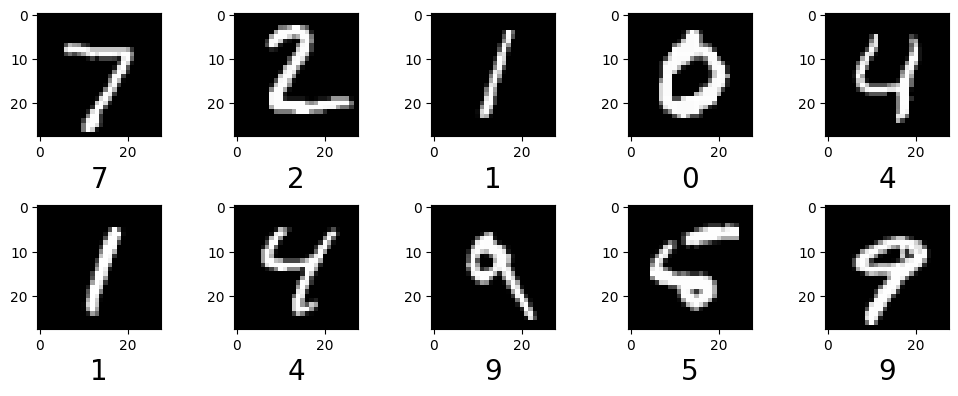

In [12]:
## plot the first 10 digits of the test set

def plot_mnist(data, labels):
    fig, ax = plt.subplots(2,5)
    fig.set_size_inches(10, 4)
    for i, axi in enumerate(ax.flat):
        # plt.subplot(2, 5, i+1)
        axi.imshow(data[i], cmap='gray')
        axi.set_xlabel(labels[i], fontsize = 20)
    plt.tight_layout()
    plt.show()
plot_mnist(X_test, y_test)

### 2. Useful methods

#### 2.1- lire_alpha_digits()

In [13]:
# data_alphadigits['classlabels'].flatten().tolist()

In [14]:
## Retrieving all the labels/characters
char_list_all = []
for array in data_alphadigits['classlabels']:
    char_list_all.append(array[0])


In [15]:
def char_to_index(char):
    '''
    Convert a character to its corresponding index in the dataset
    '''
    assert char in char_list_all, "character not in the 36 digits categories"
    return char_list_all.index(char)

In [16]:
def lire_alpha_digit(data, char_list):
    X = []
    y = []
    char_list = np.unique([char.upper() for char in char_list])
    for char in char_list:
        for i in range(39):
            X.append(data['dat'][char_to_index(char)][i].reshape(1,-1))
        y.append(char)
    return np.concatenate(X), np.array(y) ## X.shape (39*n_chars, 320), y.shape (39*n_chars,)

In [17]:
### Test
set_ABC = lire_alpha_digit(data_alphadigits, ['a','x','B','9','b','A'])
print(set_ABC[0].shape, set_ABC[1]) 

(156, 320) ['9' 'A' 'B' 'X']


#### 2.2- convert_mnist_BW()

In [18]:
def convert_mnist_black_white(X, threshold = 127):
    '''
    Convert a 3D array of mnist images to 3D array of black and white images
    '''
    X_bw = []
    for i in range(X.shape[0]):
        X_bw.append(np.where(X[i] > threshold, 1, 0))
    return np.stack(X_bw, axis = 0)

In [19]:
X_train_bw = convert_mnist_black_white(X_train)
X_test_bw = convert_mnist_black_white(X_test)

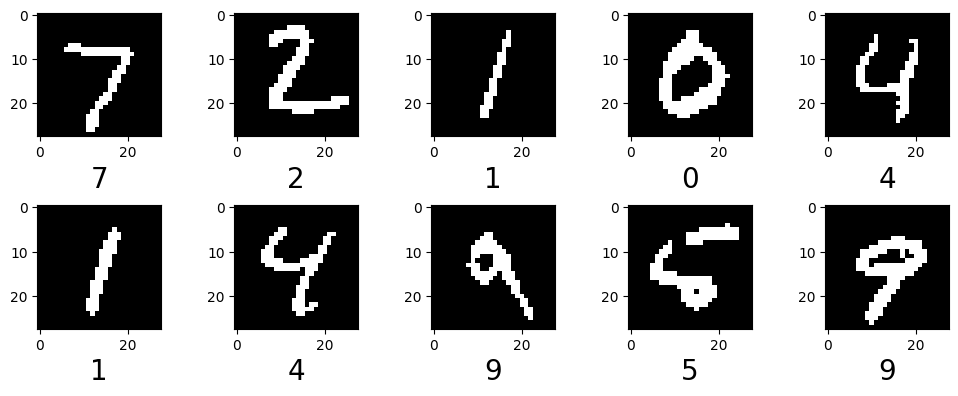

In [20]:
plot_mnist(X_test_bw[:10], y_test[:10])

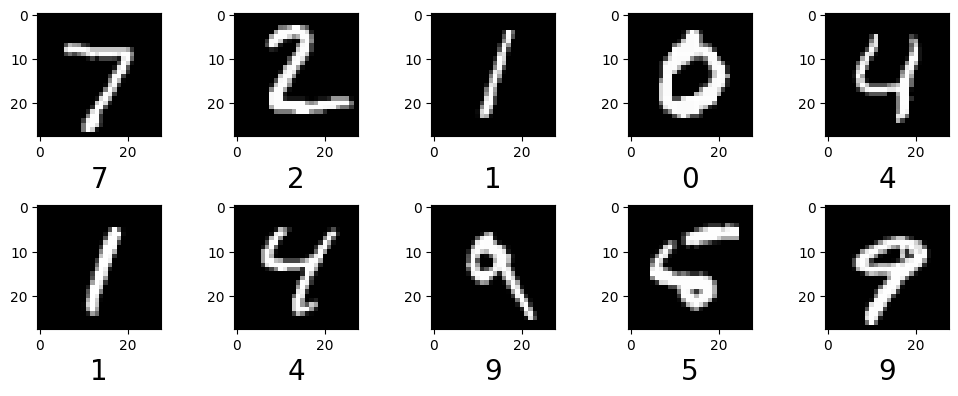

In [21]:
plot_mnist(X_test[:10], y_test[:10])

## 3. Restricted Boltzman Machine (RBM)

In [22]:
def init_RBM(input_size, output_size):
    '''
    Initialize the parameters of the RBM
    '''
    a = np.zeros((1, input_size))
    b = np.zeros((1, output_size))
    W = np.random.normal(0, 0.01, (input_size, output_size))
    return a, b, W

In [23]:
## Test
RBM = init_RBM(320, 36)

In [24]:
def entree_sortie_RBM(RBM, V):
    '''
    Compute the output of the RBM
    V : input data, visible, shape (n_samples, input_size)
    '''
    _, b, W = RBM
    return 1/(1 + np.exp(-(np.dot(V, W) + b))) ## shape (n_samples, output_size)

In [25]:
def sortie_entree_RBM(RBM, H):
    '''
    Compute the input of the RBM
    H : output data, hidden, shape (n_samples, output_size)
    '''
    a, _, W = RBM
    return 1/(1 + np.exp(-(np.dot(H, W.T) + a))) ## shape (n_samples, input_size)

In [26]:
def train_RBM(RBM, input_data, n_epochs = 1, lr=1e-3, batch_size =8, verbose = True):
    '''
    Train the RBM
    '''
    a, b, W = RBM
    loss = []
    n_samples = input_data.shape[0]
    for epoch in range(n_epochs):
        for i in range(0, n_samples//batch_size * batch_size, batch_size):
            V = input_data[i:i+batch_size].reshape(batch_size, -1)
            H = entree_sortie_RBM(RBM, V)
            V_prime = sortie_entree_RBM(RBM, H)
            H_prime = entree_sortie_RBM(RBM, V_prime)
            a += lr * (V - V_prime).sum(axis = 0)
            b += lr * (H - H_prime).sum(axis = 0)
            W += lr * (np.dot(V.T, H) - np.dot(V_prime.T, H_prime))
            loss.append(((V - V_prime)**2).mean())
        if verbose:
            print('Epoch %d/%d' % (epoch+1, n_epochs))
            print('Loss : %.4f' % loss[-1])
    return a, b, W

In [144]:
train_set, _ = lire_alpha_digit(data_alphadigits, ['k'])

print(train_set.shape)
## Shuffle  the training set
train_set = train_set[np.random.permutation(train_set.shape[0])]

(39, 320)


In [145]:
RBM = init_RBM(320, 36)
trained_RBM = train_RBM(RBM, train_set, n_epochs = 100, lr=1e-2, batch_size =4, verbose = True)

Epoch 1/100
Loss : 0.2005
Epoch 2/100
Loss : 0.1929
Epoch 3/100
Loss : 0.1911
Epoch 4/100
Loss : 0.1896
Epoch 5/100
Loss : 0.1870
Epoch 6/100
Loss : 0.1826
Epoch 7/100
Loss : 0.1761
Epoch 8/100
Loss : 0.1696
Epoch 9/100
Loss : 0.1645
Epoch 10/100
Loss : 0.1608
Epoch 11/100
Loss : 0.1580
Epoch 12/100
Loss : 0.1552
Epoch 13/100
Loss : 0.1522
Epoch 14/100
Loss : 0.1489
Epoch 15/100
Loss : 0.1452
Epoch 16/100
Loss : 0.1413
Epoch 17/100
Loss : 0.1375
Epoch 18/100
Loss : 0.1340
Epoch 19/100
Loss : 0.1309
Epoch 20/100
Loss : 0.1281
Epoch 21/100
Loss : 0.1254
Epoch 22/100
Loss : 0.1229
Epoch 23/100
Loss : 0.1204
Epoch 24/100
Loss : 0.1179
Epoch 25/100
Loss : 0.1157
Epoch 26/100
Loss : 0.1135
Epoch 27/100
Loss : 0.1116
Epoch 28/100
Loss : 0.1097
Epoch 29/100
Loss : 0.1080
Epoch 30/100
Loss : 0.1064
Epoch 31/100
Loss : 0.1049
Epoch 32/100
Loss : 0.1034
Epoch 33/100
Loss : 0.1020
Epoch 34/100
Loss : 0.1007
Epoch 35/100
Loss : 0.0995
Epoch 36/100
Loss : 0.0983
Epoch 37/100
Loss : 0.0971
Epoch 38/1

In [29]:
### Test 
## Sample 10 images from the trained RBM

In [146]:
def generer_image_RBM(n_iter_gibbs = 10, n_samples=10, trained_RBM = trained_RBM):
    '''
    Generate images from the trained RBM
    '''
    a, b, W = trained_RBM
    V = np.random.binomial(1, 0.5, (n_samples, a.shape[1])) ## initialize each component of V to bernoulli(0.5)
    #print(V)
    #plt.imshow(V[0].reshape(20,16), cmap='gray')
    for i in range(n_iter_gibbs):
        
        # This 
        H = entree_sortie_RBM(trained_RBM, V)
        V = sortie_entree_RBM(trained_RBM, H)
        
        # ## or this
        # H = np.random.binomial(1, entree_sortie_RBM(trained_RBM, V))
        # V = np.random.binomial(1, sortie_entree_RBM(trained_RBM, H))
        
        # ## or this 
        # H = np.array([1 if value >= 0.5 else 0 for row in entree_sortie_RBM(trained_RBM, V) for value in row]).reshape(n_samples, -1)
        # V = np.array([1 if value >= 0.5 else 0 for row in sortie_entree_RBM(trained_RBM, H) for value in row]).reshape(n_samples, -1)
    V = np.where(V > 0.5, 1, 0)
    #plt.imshow(V[0].reshape(20,16), cmap='gray')
    return V

In [31]:
list(map(lambda x : 1 if x >=0.5 else 0, [0.4, 0.5, 0.6]))

[0, 1, 1]

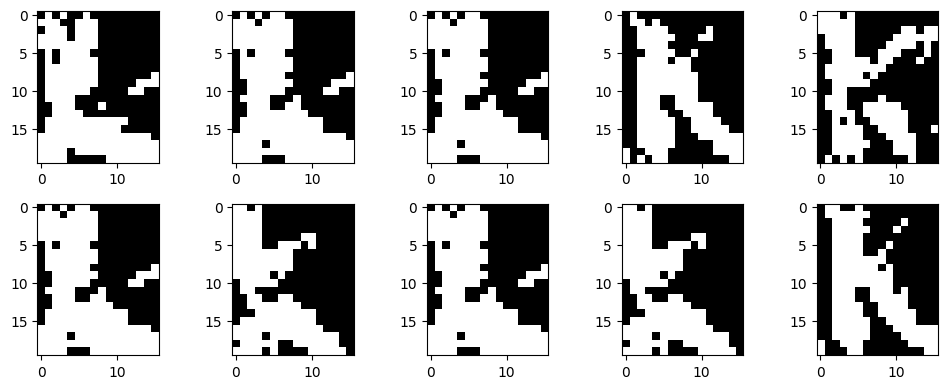

In [147]:
sampled_images = generer_image_RBM(n_iter_gibbs = 10, n_samples=10, trained_RBM = trained_RBM)

## Plot the sampled images
plot_mnist(sampled_images.reshape(-1,20,16)[:10], np.array(['']*10))

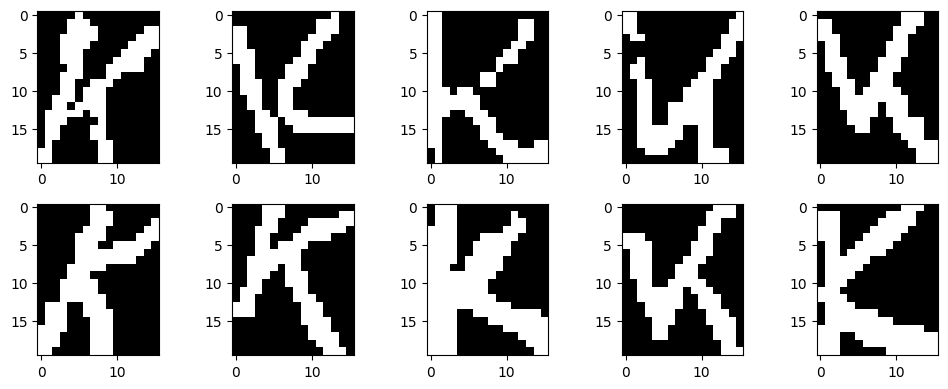

In [148]:
plot_mnist(train_set[:10].reshape(-1,20,16), np.array(['']*10))

In [149]:
## init_DBN
def init_DBN(num_layers, input_size, hidden_size):
    '''
    Initialize the parameters of the DBN
    '''
    DBN = []
    for i in range(num_layers):
        if i == 0:
            DBN.append(init_RBM(input_size, hidden_size))
        else:
            DBN.append(init_RBM(hidden_size, hidden_size))
    return DBN

In [150]:
def train_DBN(DBN, input_data, n_epochs = 1, lr=1e-3, batch_size =8, verbose = True):
    '''
    Train the DBN
    '''
    for i, RBM in enumerate(DBN):
        print('Training RBM %d/%d' % (i+1, len(DBN)))
        RBM = train_RBM(RBM, input_data, n_epochs, lr, batch_size, verbose)
        input_data = entree_sortie_RBM(RBM, input_data)
    return DBN

In [165]:
## Test on the alpha digits dataset
DBN = init_DBN(4, 320, 10)
trained_DBN = train_DBN(DBN, train_set, n_epochs = 100, lr=1e-2, batch_size =4, verbose = True)


Training RBM 1/4
Epoch 1/100
Loss : 0.2158
Epoch 2/100
Loss : 0.1968
Epoch 3/100
Loss : 0.1917
Epoch 4/100
Loss : 0.1897
Epoch 5/100
Loss : 0.1884
Epoch 6/100
Loss : 0.1872
Epoch 7/100
Loss : 0.1860
Epoch 8/100
Loss : 0.1848
Epoch 9/100
Loss : 0.1837
Epoch 10/100
Loss : 0.1825
Epoch 11/100
Loss : 0.1812
Epoch 12/100
Loss : 0.1797
Epoch 13/100
Loss : 0.1779
Epoch 14/100
Loss : 0.1757
Epoch 15/100
Loss : 0.1730
Epoch 16/100
Loss : 0.1705
Epoch 17/100
Loss : 0.1681
Epoch 18/100
Loss : 0.1658
Epoch 19/100
Loss : 0.1640
Epoch 20/100
Loss : 0.1626
Epoch 21/100
Loss : 0.1615
Epoch 22/100
Loss : 0.1605
Epoch 23/100
Loss : 0.1596
Epoch 24/100
Loss : 0.1589
Epoch 25/100
Loss : 0.1581
Epoch 26/100
Loss : 0.1575
Epoch 27/100
Loss : 0.1569
Epoch 28/100
Loss : 0.1563
Epoch 29/100
Loss : 0.1557
Epoch 30/100
Loss : 0.1552
Epoch 31/100
Loss : 0.1547
Epoch 32/100
Loss : 0.1543
Epoch 33/100
Loss : 0.1538
Epoch 34/100
Loss : 0.1534
Epoch 35/100
Loss : 0.1531
Epoch 36/100
Loss : 0.1527
Epoch 37/100
Loss : 

In [166]:
## print the shapes of each layer
for i, RBM in enumerate(trained_DBN):
    print('RBM %d' % (i+1))
    print(RBM[0].shape, RBM[1].shape, RBM[2].shape)

RBM 1
(1, 320) (1, 10) (320, 10)
RBM 2
(1, 10) (1, 10) (10, 10)
RBM 3
(1, 10) (1, 10) (10, 10)
RBM 4
(1, 10) (1, 10) (10, 10)


In [167]:
## Generate images from the trained DBN using Gibbs sampling
def generer_image_DBN(n_iter_gibbs = 10, n_samples=10, trained_DBN = trained_DBN):
    '''
    Generate images from the trained DBN
    '''
    V = np.random.binomial(1, 0.5, (n_samples, trained_DBN[0][0].shape[1])) ## initialize each component of V to bernoulli(0.5)
    for i in range(n_iter_gibbs):
        for j, RBM in enumerate(trained_DBN):
            if j == 0:
                H = entree_sortie_RBM(RBM, V)
            else:
                H = entree_sortie_RBM(RBM, H)
        for j in range(len(trained_DBN)-1, -1, -1):
            if j == len(trained_DBN)-1:
                V = sortie_entree_RBM(trained_DBN[j], H)
            else:
                V = sortie_entree_RBM(trained_DBN[j], V)
    print(V.shape)        
    V = np.where(V > 0.5, 1, 0)
    return V
            

In [170]:
sampled_images_DBN = generer_image_DBN(n_iter_gibbs = 20, n_samples=10, trained_DBN = trained_DBN)

(10, 320)


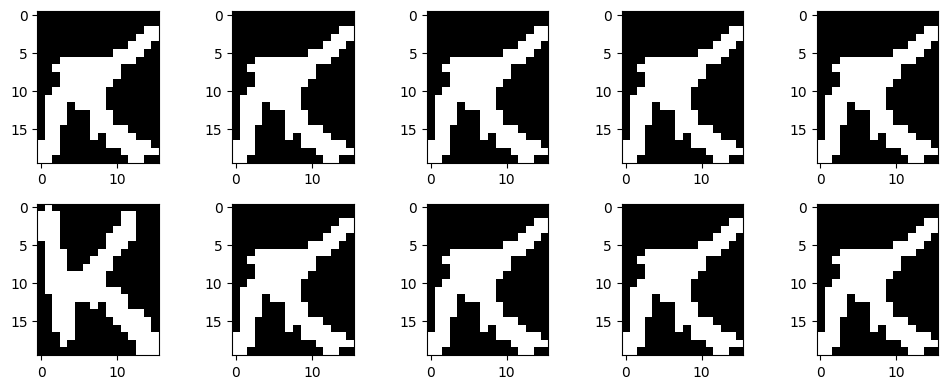

In [171]:
plot_mnist(sampled_images_DBN.reshape(-1,20,16)[:10], np.array(['']*10))